<a href="https://colab.research.google.com/github/matchbou/kaggle-study-20190410/blob/master/LSTM%20demand-forecasting-201904131809-batchsize-lstm-stateful-error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://www.kaggle.com/ashishpatel26/lstm-demand-forecasting

# LSTM demand-forecasting

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matchbou","key":"b332de8173f61d7f1a987ce8d0178075"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!pip install kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# kaggleデータ置き場とjupyernoteのカレントディレクトリフォルダを作成

!mkdir ./input
!mkdir ./notebook

In [0]:
#osライブラリ読込してinputに移動⇒kaggleデータもダウンロード　⇒ notebookフォルダに移動
import os
os.chdir('input')



In [8]:
#https://www.kaggle.com/c/demand-forecasting-kernels-only/data
!kaggle competitions download -c demand-forecasting-kernels-only

  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 80.1MB/s]
  0% 0.00/135k [00:00<?, ?B/s]
100% 135k/135k [00:00<00:00, 42.2MB/s]
  0% 0.00/3.08M [00:00<?, ?B/s]
100% 3.08M/3.08M [00:00<00:00, 102MB/s]


In [9]:
!unzip sample_submission.csv.zip -d ./
!unzip test.csv.zip -d ./
!unzip train.csv.zip -d ./


Archive:  sample_submission.csv.zip
  inflating: ./sample_submission.csv  
Archive:  test.csv.zip
  inflating: ./test.csv              
Archive:  train.csv.zip
  inflating: ./train.csv             


In [0]:
!mkdir ./demand-forecasting-kernels-only

!mv sample_submission.csv ./demand-forecasting-kernels-only
!mv test.csv   ./demand-forecasting-kernels-only
!mv train.csv      ./demand-forecasting-kernels-only

In [11]:
!pwd
!ls -a ./demand-forecasting-kernels-only

/content/input
.  ..  sample_submission.csv  test.csv	train.csv


In [0]:
#!rm ./* -r

In [0]:
os.chdir('../notebook')

In [14]:
#上記操作の結果以下のディレクトリ配置となる

# /content/notebook このipynbのカレントディレクトリ
# /content/input カグルからダウンロードしたcsvファイルの置き場所

!pwd
!ls -a ../input


/content/notebook
.   demand-forecasting-kernels-only  test.csv.zip
..  sample_submission.csv.zip	     train.csv.zip


In [0]:
#ここからカーネルの内容に踏み込む

In [47]:
#Dependencies
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import warnings
# import the_module_that_warns

warnings.filterwarnings("ignore")

from fbprophet import Prophet


## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD,Adadelta,Adam,RMSprop 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [48]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import warnings
# import the_module_that_warns

warnings.filterwarnings("ignore")

from fbprophet import Prophet


## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD,Adadelta,Adam,RMSprop 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM


In [18]:
# Input data files are available in the "../input/" directory.
# First let us load the datasets into different Dataframes
def load_data(datapath):
  data = pd.read_csv(datapath)
  # Dimensions
  print('Shape:', data.shape)
  # Set of features we have are: date, store, and item
  display(data.sample(10))
  return data
    
    
train_df = load_data('../input/demand-forecasting-kernels-only/train.csv')
test_df = load_data('../input/demand-forecasting-kernels-only/test.csv')
sample_df = load_data('../input/demand-forecasting-kernels-only/sample_submission.csv')

Shape: (913000, 4)


,date,store,item,sales
730129,2017-04-05,10,40,40
587907,2017-10-28,2,33,110
72507,2016-07-17,10,4,33
233939,2013-07-31,9,13,93
596062,2015-02-26,7,33,30
211522,2017-03-13,6,12,62
159343,2014-04-27,8,9,85
443551,2017-07-18,3,25,108
49027,2017-04-01,7,3,28
624576,2013-03-26,3,35,52


Shape: (45000, 4)


,id,date,store,item
3791,3791,2018-01-12,3,5
2326,2326,2018-03-18,6,3
11822,11822,2018-02-02,2,14
28644,28644,2018-01-25,9,32
6160,6160,2018-02-10,9,7
4432,4432,2018-01-23,10,5
5215,5215,2018-03-27,8,6
11188,11188,2018-01-29,5,13
27807,27807,2018-03-29,9,31
8833,8833,2018-01-14,9,10


Shape: (45000, 2)


,id,sales
40849,40849,52
11643,11643,52
25982,25982,52
2393,2393,52
4963,4963,52
15417,15417,52
21286,21286,52
2331,2331,52
41227,41227,52
43042,43042,52


In [19]:
# Sales distribution across the train data
def sales_dist(data):
    """
        Sales_dist used for Checing Sales Distribution.
        data :  contain data frame which contain sales data
    """
    sales_df = data.copy(deep=True)
    sales_df['sales_bins'] = pd.cut(sales_df.sales, [0, 50, 100, 150, 200, 250])
    print('Max sale:', sales_df.sales.max())
    print('Min sale:', sales_df.sales.min())
    print('Avg sale:', sales_df.sales.mean())
    print()
    return sales_df

sales_df = sales_dist(train_df)

# Total number of data points
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005

Sales bucket v/s Total percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

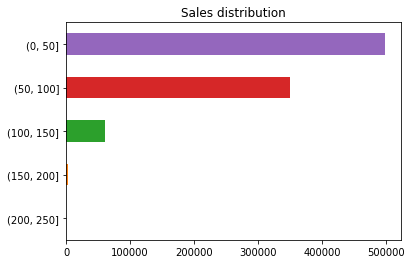

In [20]:
# Let us visualize the same
sales_count = pd.value_counts(sales_df.sales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh', title='Sales distribution', );
# sns.countplot(sales_count)

sales                                                         \
item          1          2          3          4          5          6    
store                                                                     
1      19.971522  53.148959  33.208105  19.956188  16.612815  53.060789   
2      28.173604  75.316539  46.992333  28.234940  23.540526  74.945235   
3      25.070099  66.804491  41.771084  25.116101  20.857612  67.007119   
4      22.938664  61.715225  38.548193  23.086528  19.525192  61.270537   
5      16.739321  44.488499  27.835706  16.776561  14.086528  44.564622   
6      16.717963  44.533954  27.811062  16.754107  13.893209  44.503834   
7      15.159365  40.717963  25.531216  15.358160  12.733844  40.703724   
8      26.983571  71.656627  45.076123  26.948521  22.427711  71.958379   
9      23.325849  61.792442  38.535049  23.150055  19.272180  61.412377   
10     24.736035  65.566813  41.113363  24.721249  20.637459  65.612267   

                                                     ...                 \
item          7          8          9          10    ...             41   
store                                                ...                  
1      52.783680  69.472070  46.504929  66.354326    ...      20.002738   
2      75.058598  99.090361  65.478094  94.097481    ...      28.069551   
3      66.647864  87.517525  58.486857  83.387733    ...      24.989047   
4      61.625411  80.819825  54.043812  77.047645    ...      23.168127   
5      44.535597  58.565717  38.837349  55.509858    ...      16.830778   
6      44.599124  58.385542  39.460022  55.565170    ...      16.607338   
7      40.709748  53.723987  35.901972  51.156627    ...      15.471522   
8      71.730559  94.461117  63.193319  89.818182    ...      27.036145   
9      61.812158  81.287514  54.105696  77.105148    ...      23.191128   
10     65.807777  86.176889  57.886637  82.232202    ...      24.654984   

                                                                          \
item          42         43         44          45         46         47   
store                                                                      
1      33.105696  46.242607  26.594195   72.720701  52.845016  19.814348   
2      47.368018  65.785323  37.785871  103.381161  75.219606  28.187842   
3      41.797371  58.197700  33.386090   91.851041  66.748083  25.120482   
4      38.539978  54.018620  30.952355   84.687295  61.420044  23.114458   
5      27.730559  39.163198  22.415115   61.427163  44.734940  16.699343   
6      27.893209  39.034502  22.322563   61.142935  44.539978  16.708653   
7      25.435926  35.426068  20.446331   55.905805  40.828587  15.479189   
8      45.144031  62.980285  36.194414   98.941402  72.004929  27.150055   
9      38.643483  54.152793  30.968237   85.093647  62.010953  23.003286   
10     41.222892  57.942497  32.916758   90.690581  66.046550  24.755750   

                                        
item          48         49         50  
store                                   
1      46.546002  26.461665  59.342826  
2      66.028478  37.711939  84.622125  
3      58.700986  33.259584  74.958379  
4      53.765608  30.840635  68.921687  
5      39.281490  22.371851  50.319277  
6      39.052574  22.181271  50.516429  
7      35.624315  20.406353  45.823658  
8      62.737130  36.035049  80.972070  
9      53.976999  31.052574  69.308324  
10     57.814896  33.032311  74.037240  

[10 rows x 50 columns]

<Figure size 1440x720 with 0 Axes>

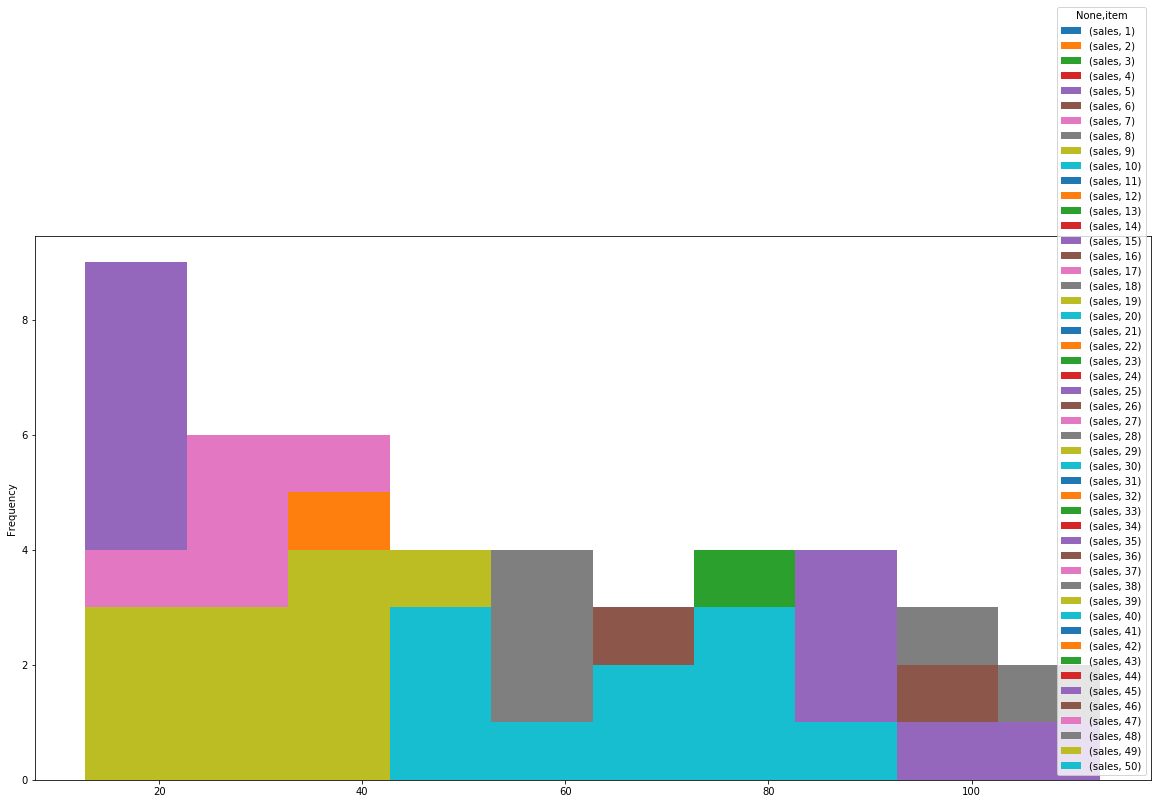

In [25]:
# Let us understand the sales data distribution across the stores
def sales_data_understanding(data):
  store_df = data.copy()
  plt.figure(figsize=(20,10))
  sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
  sales_pivoted_df.plot(kind="hist",figsize=(20,10))
  # Pivoted dataframe
  display(sales_pivoted_df)
  return (store_df,sales_pivoted_df)

store_df,sales_pivoted_df = sales_data_understanding(train_df)

In [0]:
# Let us calculate the average sales of all the items by each store
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)

In [31]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.avg_sale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.avg_sale.values,
        color = sales_across_store_df.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

In [33]:
def sales_insight(sales_pivoted_df):
    # Let us calculate the average sales of each of the item across all the stores
    sales_across_item_df = sales_pivoted_df.copy()
    # Aggregate the sales per item and add it as a new row in the same dataframe
    sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
    # Note the 11th index row, which is the average sale of each of the item across all the stores
    #display(sales_across_item_df.loc[11:])
    avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['item', 'avg_sale'])
    # And finally, sort by avg sale
    avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
    # Display the top 10 rows
    display(avg_sales_per_item_across_stores_df.head())
    return (sales_across_item_df,avg_sales_per_item_across_stores_df)

sales_across_item_df,avg_sales_per_item_across_stores_df = sales_insight(sales_pivoted_df)

,item,avg_sale
14,15,88.030778
27,28,87.881325
12,13,84.316594
17,18,84.275794
24,25,80.686418


In [34]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

In [35]:
def Time_visualization(data):
    store_item_df = data.copy()
    # First, let us filterout the required data
    store_id = 10   # Some store
    item_id = 40    # Some item
    print('Before filter:', store_item_df.shape)
    store_item_df = store_item_df[store_item_df.store == store_id]
    store_item_df = store_item_df[store_item_df.item == item_id]
    print('After filter:', store_item_df.shape)
    #display(store_item_df.head())

    # Let us plot this now
    store_item_ts_data = [go.Scatter(
        x=store_item_df.date,
        y=store_item_df.sales)]
    py.iplot(store_item_ts_data)
    return store_item_df

store_item_df = Time_visualization(train_df)

Before filter: (913000, 4)
After filter: (1826, 4)


In [36]:
def sales_monthly(data):
    multi_store_item_df = data.copy()
    # First, let us filterout the required data
    store_ids = [1, 1, 1, 1]   # Some stores
    item_ids = [10, 20, 30, 40]    # Some items
    print('Before filter:', multi_store_item_df.shape)
    multi_store_item_df = multi_store_item_df[multi_store_item_df.store.isin(store_ids)]
    multi_store_item_df = multi_store_item_df[multi_store_item_df.item.isin(item_ids)]
    print('After filter:', multi_store_item_df.shape)
    #display(multi_store_item_df)
    # TODO Monthly avg sales

    # Let us plot this now
    multi_store_item_ts_data = []
    for st,it in zip(store_ids, item_ids):
        flt = multi_store_item_df[multi_store_item_df.store == st]
        flt = flt[flt.item == it]
        multi_store_item_ts_data.append(go.Scatter(x=flt.date, y=flt.sales, name = "Store:" + str(st) + ",Item:" + str(it)))
    py.iplot(multi_store_item_ts_data)
    return (multi_store_item_df)

multi_store_item_df = sales_monthly(train_df)

Before filter: (913000, 4)
After filter: (7304, 4)


In [0]:
#LIGHTGBM
def split_data(train_data,test_data):
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])

    train_data['month'] = train_data['date'].dt.month
    train_data['day'] = train_data['date'].dt.dayofweek
    train_data['year'] = train_data['date'].dt.year

    test_data['month'] = test_data['date'].dt.month
    test_data['day'] = test_data['date'].dt.dayofweek
    test_data['year'] = test_data['date'].dt.year

    col = [i for i in test_data.columns if i not in ['date','id']]
    y = 'sales'
    train_x, test_x, train_y, test_y = train_test_split(train_data[col],train_data[y], test_size=0.2, random_state=2018)
    return (train_x, test_x, train_y, test_y,col)

train_x, test_x, train_y, test_y,col = split_data(train_df,test_df)

In [40]:
train_x.shape, test_x.shape

((730400, 5), (182600, 5))

In [41]:
# reshape input to be [samples, time steps, features]
train_x = np.array(train_x).reshape(train_x.shape[0], 1, train_x.shape[1])
test_x = np.array(test_x).reshape(test_x.shape[0], 1, test_x.shape[1])
train_x.shape,test_x.shape

((730400, 1, 5), (182600, 1, 5))

In [54]:
_optimiser = ['Adam','Nadam','RMSprop']
model = Sequential()
model.add(LSTM(144, batch_input_shape=(32, 1, 5), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=_optimiser[0])
model.summary()
#model.fit(train_x,train_y, batch_size=32,epochs=5)
#model.fit(train_x,train_y, batch_size=32,epochs=1)
model.fit(train_x,train_y, batch_size=32,epochs=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (32, 144)                 86400     
_________________________________________________________________
dense_5 (Dense)              (32, 1)                   145       
Total params: 86,545
Trainable params: 86,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
730400/730400 [==============================] - 158s 217us/step - loss: 925.8043


In [58]:
submission = pd.read_csv("../input/demand-forecasting-kernels-only/sample_submission.csv")
submission['sales'] = model.predict(test_x,batch_size=32) #上記でmodel.predictでbatch_size指定しなくてエラーなのでここでは指定。
submission.to_csv("submission_Adam")

ValueError: ignored

In [60]:
shape(test_x)

NameError: ignored